#Conexión de Drive e instalación de requisitos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Requirements Installation

## BIDS & Nibabel

In [ ]:
!pip install bids nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9c92cf5cd027eae465b18fb0dc93d7ad7a3a4696891c5ba2990c733e4ac7398e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


# Imports

In [ ]:
import os
import pandas as pd
import re
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm import tqdm
import albumentations
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import utils as vutils
from torchvision import transforms
from bids.layout import BIDSLayout
import nibabel as nib

# Model

## Helper Classes

### Group Normalization Layer

In [ ]:
class GroupNorm(nn.Module):
  def __init__(self, channels):
    super(GroupNorm, self).__init__()
    self.gn = nn.GroupNorm(num_groups = 32, num_channels=channels)

  def forward(self, x):
    return self.gn(x)

### Swish Layer

In [ ]:
class Swish(nn.Module):
  def forward(self, x):
    return x*torch.sigmoid(x)

### Residual Block

In [ ]:
#ResidualBlock
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.block = nn.Sequential(
        GroupNorm(in_channels),
        Swish(),
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        GroupNorm(out_channels),
        Swish(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        GroupNorm(out_channels),
        Swish()
    )

    if in_channels != out_channels:
      self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1 ,0)

  def forward(self, x):
    if self.in_channels != self.out_channels:
      return self.channel_up(x) + self.block(x)

    else:
      return x + self.block(x)

### Upsample Block

In [ ]:
class UpSampleBlock(nn.Module):
  def __init__(self, channels):
    super(UpSampleBlock, self).__init__()
    self.conv = nn.Conv2d(channels, channels, 3, 1 ,1)

  def forward(self, x):
    x = F.interpolate(x, scale_factor=2.0)
    return self.conv(x)

### Downsample Block

In [ ]:
class DownSampleBlock(nn.Module):
  def __init__(self, channels):
    super(DownSampleBlock, self).__init__()
    self.conv = nn.Conv2d(channels, channels, 3, 2 ,0)

  def forward(self, x):
    pad = (0, 1, 0, 1)
    x = F.pad(x, pad, mode="constant", value=0)
    return self.conv(x)

### Non Local Block

In [ ]:
class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

## Encoders

### Encoder

In [ ]:
class SoundEncoder(nn.Module):
  def __init__(self, args):
    super(SoundEncoder, self).__init__()
    channels = [128,128,128,256,256,512]
    attn_resolutions = [16]
    num_res_blocks=2
    resolution = 256
    layers=[nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
    for i in range(len(channels)-1):
      in_channels = channels[i]
      out_channels = channels[i+1]
      for j in range(num_res_blocks):
        layers.append(ResidualBlock(in_channels, out_channels))
        in_channels = out_channels
        if resolution in attn_resolutions:
          layers.append(NonLocalBlock(in_channels))
      if i != len(channels)-2:
        layers.append(DownSampleBlock(channels[i+1]))
        resolution //= 2
    layers.append(ResidualBlock(channels[-1], channels[-1]))
    layers.append(NonLocalBlock(channels[-1]))
    layers.append(ResidualBlock(channels[-1], channels[-1]))
    layers.append(GroupNorm(channels[-1]))
    layers.append(Swish())
    layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


## Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, args):
    super(Decoder, self).__init__()
    channels = [512,256,256,128,128]
    attn_resolutions=[16]
    num_res_blocks = 3
    resolution = 16
    in_channels = channels[0]

    layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
              ResidualBlock(in_channels, in_channels),
              NonLocalBlock(in_channels),
              ResidualBlock(in_channels, in_channels)]

    for i in range(len(channels)):
      out_channels = channels[i]
      for j in range(num_res_blocks):
        layers.append(ResidualBlock(in_channels, out_channels))
        in_channels = out_channels
        if resolution in attn_resolutions:
          layers.append(NonLocalBlock(in_channels))
      if i != 0:
        layers.append(UpSampleBlock(in_channels))
        resolution*=2

    layers.append(GroupNorm(in_channels))
    layers.append(Swish())
    layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1 ,1))
    self.model = nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

## Codebook

In [ ]:
class Codebook(nn.Module):
  def __init__(self, args):
    super(Codebook, self).__init__()
    self.num_codebook_vectors = args.num_codebook_vectors
    self.latent_dim = args.latent_dim
    self.beta = args.beta

    self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
    self.embedding.weight.data.uniform_(-1.0 /self.num_codebook_vectors, -1.0 /self.num_codebook_vectors)

  def forward(self, z):
    z = z.permute(0,2,3,1).contiguous()
    z_flattened = z.view(-1, self.latent_dim)

    d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
        torch.sum(self.embedding.weight ** 2, dim=1) - \
        2*torch.matmul(z_flattened, self.embedding.weight.t())

    min_encoding_indices = torch.argmin(d, dim=1)
    z_q = self.embedding(min_encoding_indices).view(z.shape)

    loss = torch.mean((z_q.detach() - z)**2 + self.beta + (z_q - z.detach())**2)

    z_q = z -(z_q.detach())

    z_q = z_q.permute(0,3,1,2)

    return z_q, min_encoding_indices, loss

## VQGAN


In [ ]:
class VQGAN(nn.Module):
  def __init__(self, args):
    super(VQGAN,self).__init__()
    self.audio_encoder = Encoder(args).to(device=args.device)
    self.cogn_encoder = Encoder(args).to(device=args.device)

    self.encoder = self.audio_encoder

    self.decoder = Decoder(args).to(device=args.device)
    self.codebook = Codebook(args).to(device=args.device)
    self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, kernel_size=1).to(device=args.device)
    self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, kernel_size=1).to(device=args.device)

  def forward(self, imgs):
    encoded_images = self.encoder(imgs)
    quant_conv_encoded_images = self.quant_conv(encoded_images)
    codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
    post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
    decoded_images = self.decoder(post_quant_conv_mapping)

    return decoded_images, codebook_indices, q_loss

  def swap_phase(self, phase):
    if phase == 1:
      self.encoder = self.audio_encoder
      self.encoder.requires_grad_(True)
      self.decoder.requires_grad_(True)
      self.codebook.requires_grad_(True)
    elif phase == 2:
      self.encoder = self.cogn_encoder
      self.encoder.requires_grad_(True)
      self.decoder.requires_grad_(False)
      self.codebook.requires_grad_(False)
    elif phase == 3:
      self.encoder = self.cogn_encoder
      self.encoder.requires_grad_(False)
      self.decoder.requires_grad_(True)
      self.codebook.requires_grad_(True)

  def encode(self, imgs):
    encoded_images = self.encoder(imgs)
    quant_conv_encoded_images = self.quant_conv(encoded_images)
    codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)

    return codebook_mapping, codebook_indices, q_loss

  def decode(self, z):
    post_quant_conv_mapping = self.post_quant_conv(z)
    decoded_images = self.decoder(post_quant_conv_mapping)

    return decoded_images

  def calculate_lambda(self, perceptual_loss, gan_loss):
    last_layer = self.decoder.model[-1]
    last_layer_weight = last_layer.weight

    perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
    gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

    l = torch.norm(perceptual_loss_grads)/(torch.norm(gan_loss_grads)-1e-4)
    l = torch.clamp(l, 0, 1e-4).detach()

    return 0.8 * l

  @staticmethod
  def adopt_weight(disc_factor, i, threshold, value=0.):
      if i < threshold:
          disc_factor = value
      return disc_factor


  def load_checkpoint(self, path):
    self.load_state_dict(torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else 'cpu')))

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
      return self.model(x)

## LPAPS

In [ ]:
#LPIP

URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self, args):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained(args)

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, args, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, args.work_dir)
        self.load_state_dict(torch.load(ckpt, map_location=torch.device(args.device)), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])



class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale

class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

#Utils

## Data Utilities

In [ ]:
#Prepare dataset
class MRISOUND(Dataset):
  def __init__(self, dataset_path, size=None, train = True, preprocess=False):

      self.stimuli_path = os.path.join(dataset_path, "stimuli")

      self.preprocessed_input_path = os.path.join(dataset_path, "slices")
      self.preprocessed_target_path = os.path.join(dataset_path, "mel")

      if not os.path.isdir(self.preprocessed_input_path):
        os.mkdir(self.preprocessed_input_path)
      if not os.path.isdir(self.preprocessed_target_path):
        os.mkdir(self.preprocessed_target_path)

      self.train = train
      self.size = size
      if preprocess:
        self.preprocessor = Preprocessor(dataset_path, self.preprocessed_input_path, self.preprocessed_target_path, self.size)
        self.preprocess()
      else:
        self.get_data()

  def __len__(self):
      return self._length

  def preprocess(self, saveDir=True):
      self.preprocessor.preprocess_sound(self.stimuli_path, saveDir)
      #self.preprocessor.get_slices(saveDir)
      self.get_data()
      self._length = len(self.images)

  def get_data(self):
      self.sounds = os.listdir(self.preprocessed_target_path)
      self.images = os.listdir(self.preprocessed_input_path)
      self._length = len(self.images)

  def __getitem__(self, idx):
      pattern = re.compile("ni_sub-(?P<sub>\d{2})_session-(?P<session>\d{2})_run-(?P<run>\d{2})_stimuli-(?P<file>.*).tiff")
      image = os.path.join(self.preprocessed_input_path, self.images[idx])
      images = [os.path.join(self.preprocessed_input_path, image) for image in os.listdir()]
      try:
        sound_file = re.match(pattern, self.images[idx]).group("file")
      except AttributeError:
        print(images[idx])
      sound = os.path.join(self.preprocessed_target_path, sound_file+".tiff")
      return (image, sound)


class Preprocessor():

  def __init__(self, data_path, input_path, target_path, size=None):

      self.data_path = data_path
      self.input_path = input_path
      self.target_path = target_path

      self.layout = BIDSLayout(data_path)
      self.subjects = self.layout.get(return_type="id", target="subject")

      self.size = size

      self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
      self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
      self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])


  def retrieve_data(self):
      return self.sounds, self.images

  def get_low_bold_signal_sl(self, idx, high_bold_time, volumes, st):
      sl_time = high_bold_time
      low_bold_idx = idx
      while sl_time > high_bold_time - 5:
        sl_time -= st[low_bold_idx%len(st)]
        low_bold_idx -= 1
      return volumes[:,:,low_bold_idx%volumes.shape[2], low_bold_idx//volumes.shape[2]]


  def get_slices(self, saveDir=False):
      self.images = []
      for subject in tqdm(self.subjects):
        for session in self.layout.get(return_type="id", target="session", subject=subject):
          for run in self.layout.get(return_type="id", target="run", session=session, subject=subject):
            events = self.layout.get(return_type="file", extension="tsv", subject=subject, session=session, run=run)
            blank_image = None
            if len(events) <= 0:
              continue
            events = pd.read_table(events[0])
            for ni in self.layout.get(return_type="file", extension=["nii.gz", "nii"],subject=subject, session=session, run=run):
              try:
                st = self.layout.get_metadata(ni)["SliceTiming"]
              except KeyError:
                continue
              else:
                n_file = nib.load(ni)
                break
            n_data = n_file.get_fdata()
            # Preprocess NI
            #We need to remove dummy scans so the first 'dummy' volumes of data will be discarded
            dummy = 12
            sl_onset = 0
            sl_idx = 12*n_data.shape[3]

            for onset in events["onset"]:
              t_name = events.loc[events["onset"] == onset, "stim_file"].iloc[0]
              while sl_onset <= onset+5: # Cogemos el slice que contiene el momento 5 segundos después del estímulo para encontrar el pico de la señal BOLD
                # Para el slice axial i se tarda SliceTiming[i] tiempo en tomar
                sl_onset += st[sl_idx%len(st)]
                sl_idx += 1
              self.sounds.append(t_name)

              high_bold_slice = n_data[:,:,sl_idx%n_data.shape[2],sl_idx//n_data.shape[2]]
              low_bold_slice = self.get_low_bold_signal_sl(sl_idx, sl_onset, n_data, st)

              try:
                img = self.preprocess_image(np.abs(high_bold_slice-low_bold_slice))
                if saveDir:
                  img.save(os.path.join(self.input_path,f"ni_sub-{subject}_session-{session}_run-{run}_stimuli-{t_name}.tiff"))
                self.images.append(os.path.join(self.input_path,f"ni_sub-{subject}_session-{session}_run-{run}_stimuli-{t_name}.tiff"))
              except IndexError:
                print("Data shape: ", n_data.shape)
                print("Index tried: ", sl_idx%n_data.shape[2])

  def preprocess_image(self, sl):
    image = sl
    image = self.preprocessor(image=image)["image"]
    image = (image / 127.5 - 1.0).astype(np.float64)
    image = Image.fromarray(image)
    return image

  def preprocess_sound(self, sound_path, saveDir = True):
    # Preprocess Sound
    self.sounds = []
    mel = None
    for file in tqdm(os.listdir(sound_path)):
      y, sr = librosa.load(os.path.join(sound_path, file))
      mel = librosa.feature.melspectrogram(y=y, sr = sr, n_fft=1024, hop_length=256)
      sound = librosa.power_to_db(mel, ref=np.max)
      padding = 96-sound.shape[1]
      padding = np.ones((sound.shape[0], padding), np.float64)*np.min(sound)
      sound = np.concatenate((sound, padding), axis=1)
      sound = ((sound - np.min(sound))/np.max(np.abs(sound))).astype(np.float64)
      if saveDir:
        img = Image.fromarray(sound)
        img.save(os.path.join(self.target_path, file+".tiff"))
      self.sounds.append(os.path.join(self.target_path, file+".tiff"))

def load_data(args):
    train_data = MRISOUND(args.dataset_path, size=232, preprocess=args.preprocess)
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
    return train_loader

## Module Utils

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(input, rec):
    im = np.cat((input, rec))
    plt.imshow(im)

## Arguments Util
Ésta clase solo es necesaria para ejecutar en colab para pasar los argumentos como un diccionario, de otra manera es preferible utilizar argsparse

In [ ]:
class Arguments:
  def __init__(self, args):
    for k, v in args.items():
      setattr(self, k, v)

# Trainer

In [ ]:
class Trainer:
  def __init__(self, args):
    self.work_dir = args.work_dir
    self.results_dir = os.path.join(self.work_dir, "results")
    self.checkpoint_dir = os.path.join(self.work_dir, "checkpoints")

    self.vqgan = VQGAN(args).to(device=args.device)
    if args.checkpoint is not None:
      self.vqgan.load_checkpoint(os.path.join(self.checkpoint_dir, args.checkpoint))
    self.decoder = Decoder(args).to(device=args.device)
    self.codebook = Codebook(args).to(device=args.device)
    self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, kernel_size=1).to(device=args.device)
    self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, kernel_size=1).to(device=args.device)
    self.discriminator = Discriminator(args).to(device=torch.device(args.device))
    self.discriminator.apply(weights_init)
    self.discriminator.to(device=torch.device(args.device))
    self.perceptual_loss = LPIPS(args).eval().to(device=torch.device(args.device))
    self.opt_vq, self.opt_disc = self.configure_optimizers(args)

    self.prepare_training(args.work_dir)

  def configure_optimizers(self, args):
    lr = args.learning_rate
    opt_vq = torch.optim.Adam(
        list(self.vqgan.encoder.parameters()) + \
        list(self.vqgan.decoder.parameters()) + \
        list(self.vqgan.codebook.parameters()) + \
        list(self.vqgan.quant_conv.parameters()) + \
        list(self.vqgan.post_quant_conv.parameters()),
        lr=lr, eps = 1e-8, betas=(args.beta1, args.beta2)
    )
    opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, eps=1e-8, betas=(args.beta1, args.beta2))

    return opt_vq, opt_disc

  @staticmethod
  def prepare_training(work_dir):
    os.makedirs(os.path.join(work_dir, "results"), exist_ok=True)
    os.makedirs(os.path.join(work_dir, "checkpoints"), exist_ok=True)

  def train_phase1(self, args):
    self.vqgan.swap_phase(1)
    train_dataset = load_data(args)
    steps_per_epoch = len(train_dataset)
    for epoch in range(args.epochs):
        with tqdm(range(len(train_dataset))) as pbar:
            for i, (_, s_names) in zip(pbar, train_dataset):
                sounds = np.array(Image.open(s_names[0]))
                sounds = np.reshape(sounds, (1, 1, sounds.shape[0], sounds.shape[1]))
                sounds = torch.tensor(sounds).to(device=args.device)

                decoded_images, _, q_loss = self.vqgan(sounds)

                disc_real = self.discriminator(sounds)
                disc_fake = self.discriminator(decoded_images)

                disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                perceptual_loss = self.perceptual_loss(sounds, decoded_images)
                rec_loss = torch.abs(sounds - decoded_images)
                perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                perceptual_rec_loss = perceptual_rec_loss.mean()
                g_loss = -torch.mean(disc_fake)

                λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                d_loss_real = torch.mean(F.relu(1. - disc_real))
                d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                self.opt_vq.zero_grad()
                vq_loss.backward(retain_graph=True)

                self.opt_disc.zero_grad()
                gan_loss.backward()

                self.opt_vq.step()
                self.opt_disc.step()

                if i % 1000 == 0:
                    with torch.no_grad():
                        real_fake_images = torch.cat((sounds[:4], decoded_images[:4]))
                        vutils.save_image(real_fake_images, os.path.join(self.results_dir, f"{epoch}_{i}.jpg"), nrow=4)

                pbar.set_postfix(
                    VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                    GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                )
                pbar.update(0)
            torch.save(self.vqgan.state_dict(), os.path.join(self.checkpoint_dir, f"vqgan_phase_1_epoch_{epoch}.pt"))

  def train_phase2(self, args):
    self.vqgan.swap_phase(2)
    train_dataset = load_data(args)
    steps_per_epoch = len(train_dataset)
    for epoch in range(args.epochs):
        with tqdm(range(len(train_dataset))) as pbar:
            for i, (images, sounds) in zip(pbar, train_dataset):
                sounds = np.array(Image.open(sounds[0]))
                images = np.array(Image.open(images[0]))

                sounds = np.reshape(sounds, (1, 1, sounds.shape[0], sounds.shape[1]))
                sounds = torch.tensor(sounds).to(device=args.device)

                images = np.reshape(images, (1, 1, images.shape[0], images.shape[1]))
                images = torch.tensor(images).to(device=args.device)

                decoded_images, _, q_loss = self.vqgan(images)

                disc_real = self.discriminator(sounds)
                disc_fake = self.discriminator(decoded_images)

                disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                perceptual_loss = self.perceptual_loss(sounds, decoded_images)
                rec_loss = torch.abs(sounds - decoded_images)
                perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                perceptual_rec_loss = perceptual_rec_loss.mean()
                g_loss = torch.abs(torch.mean(disc_fake))

                λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                d_loss_real = torch.mean(F.relu(1. - disc_real))
                d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                self.opt_vq.zero_grad()
                vq_loss.backward(retain_graph=True)

                self.opt_disc.zero_grad()
                gan_loss.backward()

                self.opt_vq.step()
                self.opt_disc.step()

                if i % 100 == 0:
                    with torch.no_grad():
                        real_fake_images = torch.cat((sounds[:4], decoded_images[:4]))
                        plot_images(sounds, decoded_images)
                        vutils.save_image(real_fake_images, os.path.join(self.results_dir, f"{epoch}_{i}.jpg"), nrow=4)

                pbar.set_postfix(
                    VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                    GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                )
                pbar.update(0)
            torch.save(self.vqgan.state_dict(), os.path.join(self.checkpoint_dir, f"vqgan_phase_3_epoch_{epoch}.pt"))

  def train_phase3(self, args):
    self.vqgan.swap_phase(3)
    train_dataset = load_data(args)
    steps_per_epoch = len(train_dataset)
    for epoch in range(args.epochs):
        with tqdm(range(len(train_dataset))) as pbar:
            for i, (images, sounds) in zip(pbar, train_dataset):
                sounds = np.array(Image.open(sounds[0]))
                images = np.array(Image.open(images[0]))

                sounds = np.reshape(sounds, (1, 1, sounds.shape[0], sounds.shape[1]))
                sounds = torch.tensor(sounds).to(device=args.device)

                images = np.reshape(images, (1, 1, images.shape[0], images.shape[1]))

                decoded_images, _, q_loss = self.vqgan(images)

                disc_real = self.discriminator(sounds)
                disc_fake = self.discriminator(decoded_images)

                disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                perceptual_loss = self.perceptual_loss(sounds, decoded_images)
                rec_loss = torch.abs(sounds - decoded_images)
                perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                perceptual_rec_loss = perceptual_rec_loss.mean()
                g_loss = torch.abs(torch.mean(disc_fake))

                λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                d_loss_real = torch.mean(F.relu(1. - disc_real))
                d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                self.opt_vq.zero_grad()
                vq_loss.backward(retain_graph=True)

                self.opt_disc.zero_grad()
                gan_loss.backward()

                self.opt_vq.step()
                self.opt_disc.step()

                if i % 100 == 0:
                    with torch.no_grad():
                        real_fake_images = torch.cat((sounds[:4], decoded_images[:4]))
                        vutils.save_image(real_fake_images, os.path.join(self.results_dir, f"{epoch}_{i}.jpg"), nrow=4)

                pbar.set_postfix(
                    VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                    GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                )
                pbar.update(0)
            torch.save(self.vqgan.state_dict(), os.path.join(self.checkpoint_dir, f"vqgan_epoch_{epoch}.pt"))

# Setup

In [1]:
args_vqgan ={
    'mode': "gen",
    'checkpoint': "vqgan_epoch_2.pt",
    'latent_dim': 256,
    'image_channels': 1,
    'cogn_size': 208,
    'sound_size': 208,
    'num_codebook_vectors': 128,
    'beta': 0.25,
    'dataset_path': './drive/MyDrive/MRIVQGEN/ds004814', # dataset ID from openneuro
    'preprocess': False,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 1,
    'epochs': 5,
    'learning_rate': 1e-6,
    'beta1': 0.5,
    'beta2': 0.9,
    'disc_start': 300,
    'disc_factor': 10,
    'rec_loss_factor': 2,
    'perceptual_loss_factor':5,
    'work_dir': './drive/MyDrive/MRIVQGEN'
}
args_vqgan = Arguments(args_vqgan)

NameError: name 'torch' is not defined

In [ ]:
if not os.path.isdir(args_vqgan.work_dir):
  os.mkdir(args_vqgan.work_dir)

# Training

El entrenamiento consiste en 3 etapas. En la primera entrenamos el encodificador de audio, el codebook y el decodificador. En la segunda, entrenamos el encodificador cognitivo manteniendo congelados el codebook y el decodificador. Por último, congelamos el encodificador cognitivo y reentrenamos el codebook y el decodificador.

## Stage 1
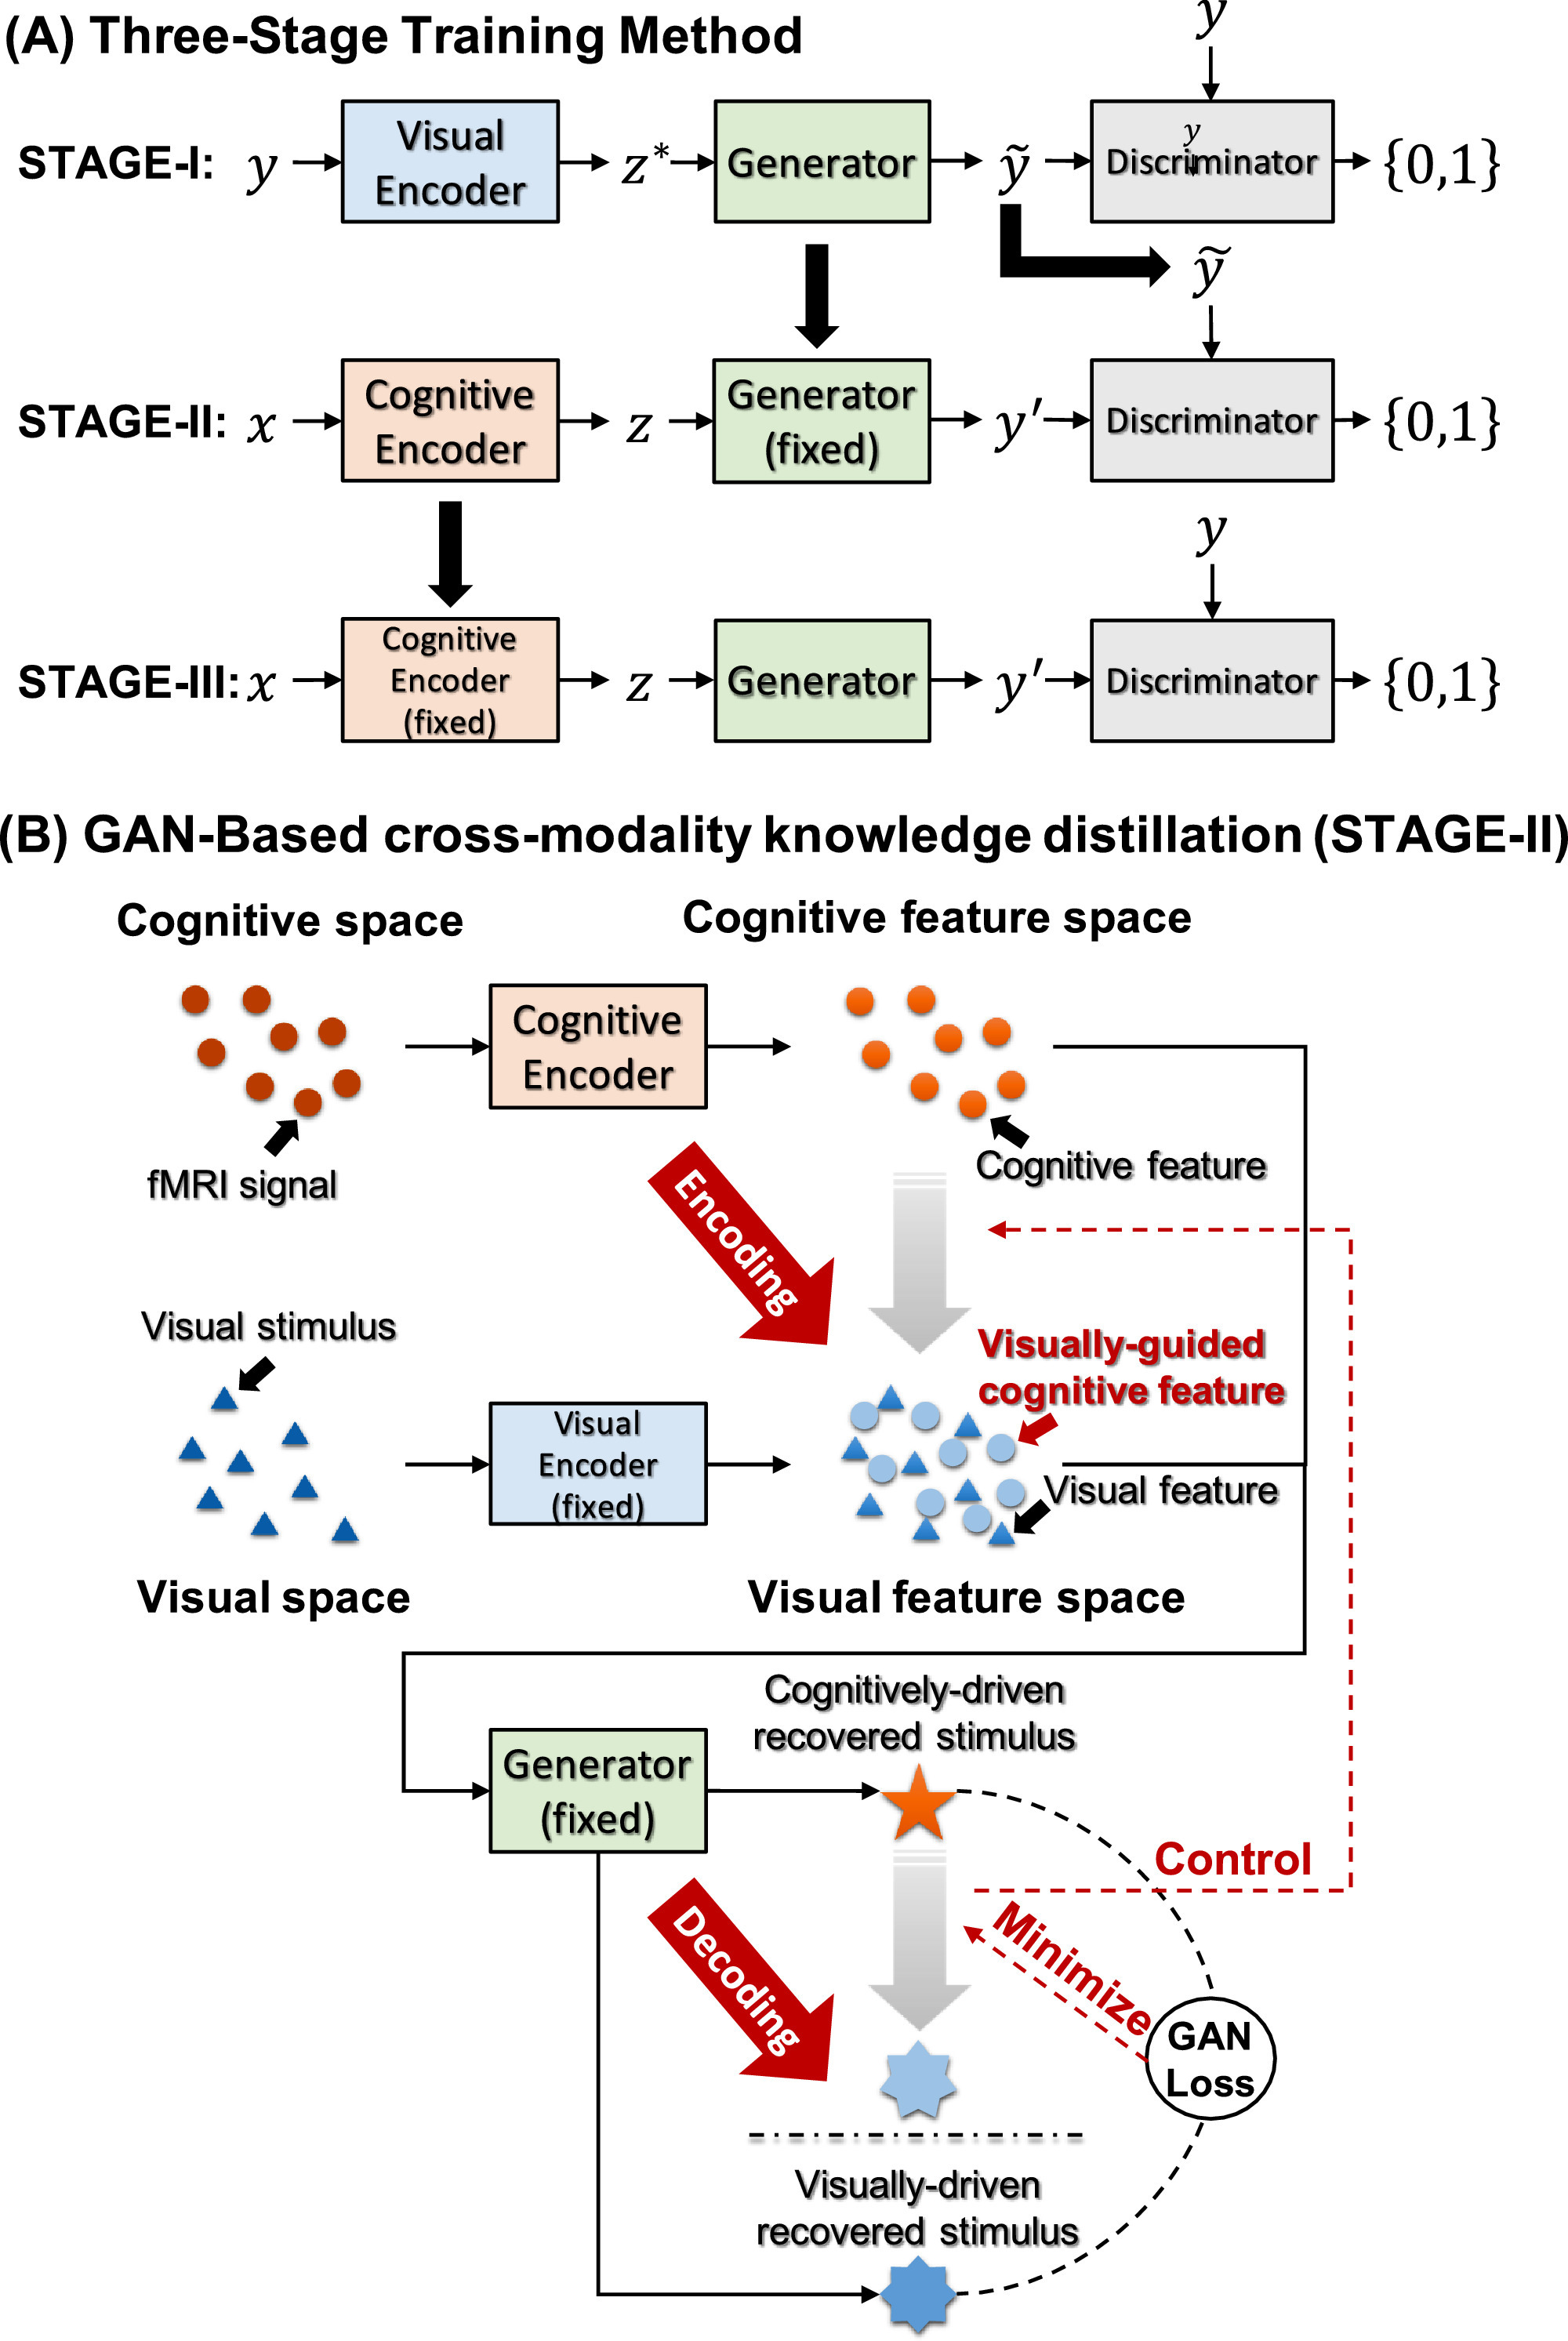
audio -> E_aud -> C -> V -> rec_audio


In [ ]:
trainer = Trainer(args_vqgan)

In [ ]:
trainer.train_phase2(args_vqgan)

  0%|          | 0/6038 [00:00<?, ?it/s]


AssertionError: ignored

## Stage 2

## Stage 3